This notebook contains the analysing the **metrics** of initial experiments, particularily an experiment that involved taking all symbols available (1698) and training a model per symbol. We then generate symbol stability metrics. Each symbol then becomes associated with performance metrics and stability features. We perform some experimentation on these features (filtering and monitoring the average MAPE of the remaining symbols, and visualizing). Finally we automate this process by implementing a classification model.

In [2]:
#!pip install ipywidgets matplotlib plotly bokeh dask
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
from tqdm import tqdm
import glob
import gzip
from statsmodels.tsa.stattools import acf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


%matplotlib inline

In [2]:
folder_path = "/gpfs/home5/talkanbar/"
file_name3 = "combined_fixed_optimized_df1.pkl"
file_path = os.path.join(folder_path, file_name3)
df = pd.read_pickle(file_path)

In [3]:
#This is the experiment that involved training all symbols on NBEATS model , raw data, but one model per symbol. We will analyse the result
folder_path = "/gpfs/home5/talkanbar/GIT/Metrics"
file_name3 = "metrics_df_all_per_symbol_raw.pkl"
file_path = os.path.join(folder_path, file_name3)
all_per_symbol_raw = pd.read_pickle(file_path)
all_per_symbol_raw = all_per_symbol_raw.rename(columns={'Symbol': 'symbol'})

In [4]:
folder_path = "/gpfs/home5/talkanbar/GIT/Metrics"
file_name3 = "metrics_one4all_10days_raw_NB.pkl"
file_path = os.path.join(folder_path, file_name3)
ini_nbeats = pd.read_pickle(file_path)
ini_nbeats = ini_nbeats.rename(columns={'Symbol': 'symbol'})

In [5]:
file_name3 = "metrics_one4all_10days_raw_RNN.pkl"
file_path = os.path.join(folder_path, file_name3)
ini_rnn = pd.read_pickle(file_path)

In [6]:
file_name3 = "metrics_one4all_10days_raw_filteredmoneyness_NB.pkl"
file_path = os.path.join(folder_path, file_name3)
ini_nbeats_filter_moneyness = pd.read_pickle(file_path)

In [7]:
file_name3 = "metrics_one4all_10days_raw_filteredmoneyness_RNN.pkl"
file_path = os.path.join(folder_path, file_name3)
ini_rnn_filter_moneyness = pd.read_pickle(file_path)

In [8]:

file_name3 = "metrics_df_all_per_symbol_raw.pkl"
file_path = os.path.join(folder_path, file_name3)
persymbol = pd.read_pickle(file_path)

In [15]:
#this is to report the results of the third initial experiment ( First 10 days, one model per symbol, (594 symbols) 
symbols_to_include = ini_nbeats['symbol'].unique()

ini_persymbol = persymbol[persymbol['symbol'].isin(symbols_to_include)].copy()
ini_persymbol = ini_persymbol.rename(columns={'symbol': 'Symbol'})


In [19]:
len(ini_persymbol['Symbol'].unique())

594

In [20]:
ini_rnn.columns = ini_rnn.columns.str.replace('_RNN', '')
ini_rnn_filter_moneyness.columns = ini_rnn_filter_moneyness.columns.str.replace('_RNN', '')

Results of initial experiments:

In [13]:
metrics_dfs_dict = {
    'ini_nbeats': ini_nbeats,
    'ini_rnn': ini_rnn,
    'ini_nbeats_filter_moneyness': ini_nbeats_filter_moneyness,
    'ini_rnn_filter_moneyness': ini_rnn_filter_moneyness,
    'ini_persymbol': ini_persymbol
}
formatted_results = []
for df_name, df_data in metrics_dfs_dict.items():
    stats = df_data[['MAE', 'RMSE', 'MAPE']].agg(['mean', 'std'])
    mae_formatted = f"{stats.loc['mean', 'MAE']:.2f} \u00B1 {stats.loc['std', 'MAE']:.2f}"
    rmse_formatted = f"{stats.loc['mean', 'RMSE']:.2f} \u00B1 {stats.loc['std', 'RMSE']:.2f}"
    mape_formatted = f"{stats.loc['mean', 'MAPE']:.4f} \u00B1 {stats.loc['std', 'MAPE']:.4f}" # More precision for MAPE
    formatted_results.append({
        'DataFrame': df_name,
        'MAE': mae_formatted,
        'RMSE': rmse_formatted,
        'MAPE': mape_formatted
    })
comparison_table = pd.DataFrame(formatted_results).set_index('DataFrame')
comparison_table

,MAE,RMSE,MAPE
DataFrame,,,
ini_nbeats,4168.47 ± 43959.77,8947.53 ± 104148.41,2840.2351 ± 39924.3516
ini_rnn,692.96 ± 1154.51,1150.80 ± 1764.89,412.2240 ± 1311.9771
ini_nbeats_filter_moneyness,3051.12 ± 31724.70,7096.02 ± 93407.84,6951.1729 ± 111835.4141
ini_rnn_filter_moneyness,556.41 ± 712.56,944.37 ± 1248.22,307.7602 ± 626.0067
ini_persymbol,3829.29 ± 44076.79,7116.61 ± 83406.71,2339.0342 ± 29588.8652


In [11]:
avg_moneyness = df.groupby('symbol')['moneyness'].mean().reset_index()
avg_moneyness = avg_moneyness.rename(columns={'moneyness': 'avg_moneyness'})

In [20]:
ini_nbeats = ini_nbeats.merge(avg_moneyness, on='symbol', how='left')
correlation = ini_nbeats['MAPE'].corr(ini_nbeats['avg_moneyness'])
print(f"Correlation between avg moneyness and MAPE: {correlation:.4f}")

Correlation between avg moneyness and MAPE: -0.0172


## Symbol Stability Features

In [ ]:
#generating the feaetures but only taking the training period (no leakage)

df = df.sort_values(['symbol', 'timestamp'])

# Function to compute training-period stats per symbol
def compute_training_volatility(group):
    n = int(len(group) * 0.8)
    train = group.iloc[:n]
    mean_80 = train['mid_price_usd'].mean()
    std_80 = train['mid_price_usd'].std()
    ratio_80 = std_80 / (mean_80 + 1e-6)
    return pd.Series({
        'mid_price_mean_symbol_80': mean_80,
        'mid_price_std_symbol_80': std_80,
        'mid_price_volatility_ratio_80': ratio_80
    })


vol_stats_80 = df.groupby('symbol').apply(compute_training_volatility).reset_index()

# Merge back into original df
df = df.merge(vol_stats_80, on='symbol', how='left')
#now each symbol has mid_price_volatility_ratio_80 metric, we did the same for other metrics
#we will experiment with it and see how filtering affect MAPE, and  keep generating more metrics 

# Mid price range ratio (max / min)
df_80['mid_price_range_80'] = df_80.groupby('symbol')['mid_price_usd'].transform(lambda x: x.max() / (x.min() + 1e-6))
range_per_symbol_80 = df_80.groupby('symbol')['mid_price_range_80'].max().reset_index()

# Max jump (absolute diff)
def max_jump(x):
    return (x.diff().abs()).max()

df_80['mid_price_jump_80'] = df_80.groupby('symbol')['mid_price_usd'].transform(max_jump)
jump_per_symbol_80 = df_80.groupby('symbol')['mid_price_jump_80'].max().reset_index()

# Step 4: Anomaly ratio
df_80['mid_price_pct_change_80'] = df_80.groupby('symbol')['mid_price_usd'].transform(lambda x: x.pct_change().abs())
df_80['is_anomalous_80'] = df_80['mid_price_pct_change_80'] > 0.5 #threshold we determined  after some experimentation

anomaly_ratio_80 = df_80.groupby('symbol')['is_anomalous_80'].mean().reset_index(name='anomaly_rate_80')

df = df.merge(range_per_symbol_80, on='symbol', how='left')
df = df.merge(jump_per_symbol_80, on='symbol', how='left')
df = df.merge(anomaly_ratio_80, on='symbol', how='left')

In [31]:
metrics_df=all_per_symbol_raw
risk_features = [
'mid_price_range_80',	'mid_price_jump_80',	'anomaly_rate_80',	'mid_price_volatility_ratio_80'
]
columns_for_correlation = ['MAPE'] + risk_features

correlation_matrix = metrics_df[columns_for_correlation].corr()

correlation_with_mape = correlation_matrix['MAPE'][risk_features]

print("Correlation with MAPE:")
print(correlation_with_mape)

Correlation with MAPE:
mid_price_range_80               0.052500
mid_price_jump_80                0.048355
anomaly_rate_80                  0.027200
mid_price_volatility_ratio_80    0.040795
Name: MAPE, dtype: float64


how filtering out a percentage of the most volatile symbols (based on 'mid_price_volatility_ratio_80' or Coeffiecient of Variation) impacts the distribution of the MAPEfor the remaining data.

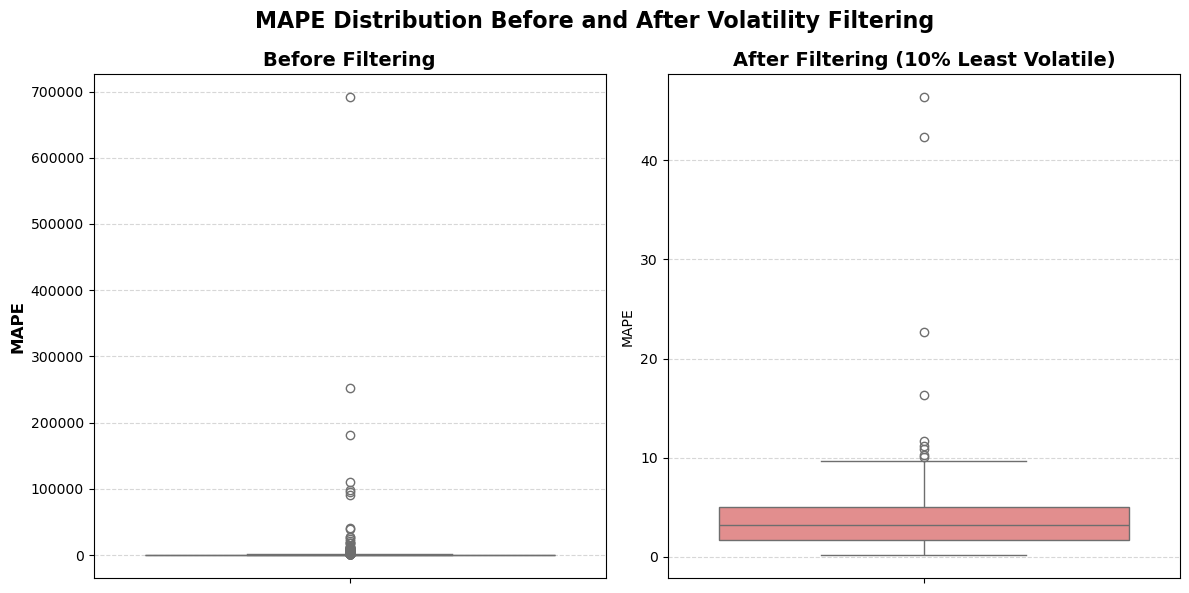

In [27]:
#let's select most volatile symbols and exclude them
metrics_df=all_per_symbol_raw
threshold = metrics_df['mid_price_volatility_ratio_80'].quantile(0.10)
filtered_metrics_df = metrics_df[metrics_df['mid_price_volatility_ratio_80'] <= threshold].copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False) 
fig.suptitle('MAPE Distribution Before and After Volatility Filtering', fontsize=16, fontweight='bold')

# MAPE before filtering
sns.boxplot(y=metrics_df['MAPE'], ax=axes[0], color='skyblue')
axes[0].set_title('Before Filtering', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAPE', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='y', labelsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# MAPE after filtering
sns.boxplot(y=filtered_metrics_df['MAPE'], ax=axes[1], color='lightcoral')
axes[1].set_title('After Filtering (10% Least Volatile)', fontsize=14, fontweight='bold')
# You can remove or keep the next line as you prefer, if sharey is False, the ylabel will show up on both axes.
# axes[1].set_ylabel('')
axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

So if we exclude the most volatile symbols and keep only best 10% based only on one feature, we can improve MAPE a lot. Thus there is some potential! Let's experiment further:

Here trying to explore if there is a correlation between MAPE and volatility ratio

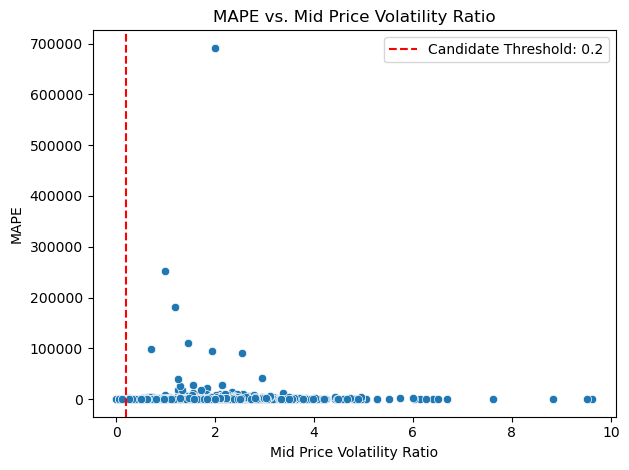

In [37]:


sns.scatterplot(
    data=metrics_df,
    x='mid_price_volatility_ratio_80',
    y='MAPE'
)
plt.axvline(0.2, color='red', linestyle='--', label='Candidate Threshold: 0.2')
plt.title('MAPE vs. Mid Price Volatility Ratio')
plt.xlabel('Mid Price Volatility Ratio')
plt.ylabel('MAPE')
plt.legend()
plt.tight_layout()
plt.show()

320
Average MAPE after filtering (volatility ratio ≤ 0.2): 9.4181


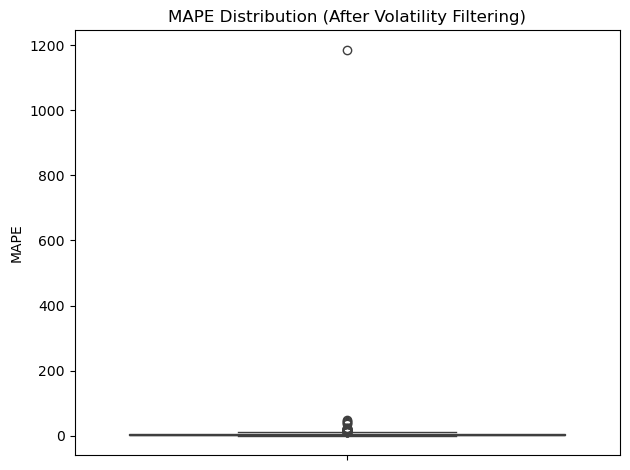

In [38]:
#trying to manually filter on volatility and seeing if it affects average MAPE. (done many times)
threshold = 0.2  

filtered_metrics_df = metrics_df[
    metrics_df['mid_price_volatility_ratio_80'] <= threshold
]
print(len(filtered_metrics_df))
average_mape = filtered_metrics_df['MAPE'].mean()
print(f"Average MAPE after filtering (volatility ratio ≤ {threshold}): {average_mape:.4f}")

sns.boxplot(y=filtered_metrics_df['MAPE'])
plt.title('MAPE Distribution (After Volatility Filtering)')
plt.ylabel('MAPE')
plt.tight_layout()
plt.show()


Example on how I tracked poor performing symbols and investigated their mid price to explore if there is a pattern

In [ ]:
mean_mape_per_symbol_filtered = filtered_df1.groupby('Symbol')['MAPE'].mean()


sorted_by_mape_filtered = mean_mape_per_symbol_filtered.sort_values(ascending=False)

# Get the worst performing symbol (the one with the highest mean MAPE)
worst_performing_symbol_filtered = sorted_by_mape_filtered.head(2)

print(worst_performing_symbol_filtered)


Symbol
BTC-2JAN25-92500-C    265.851166
BTC-6JAN25-96500-C    136.412766
Name: MAPE, dtype: float3

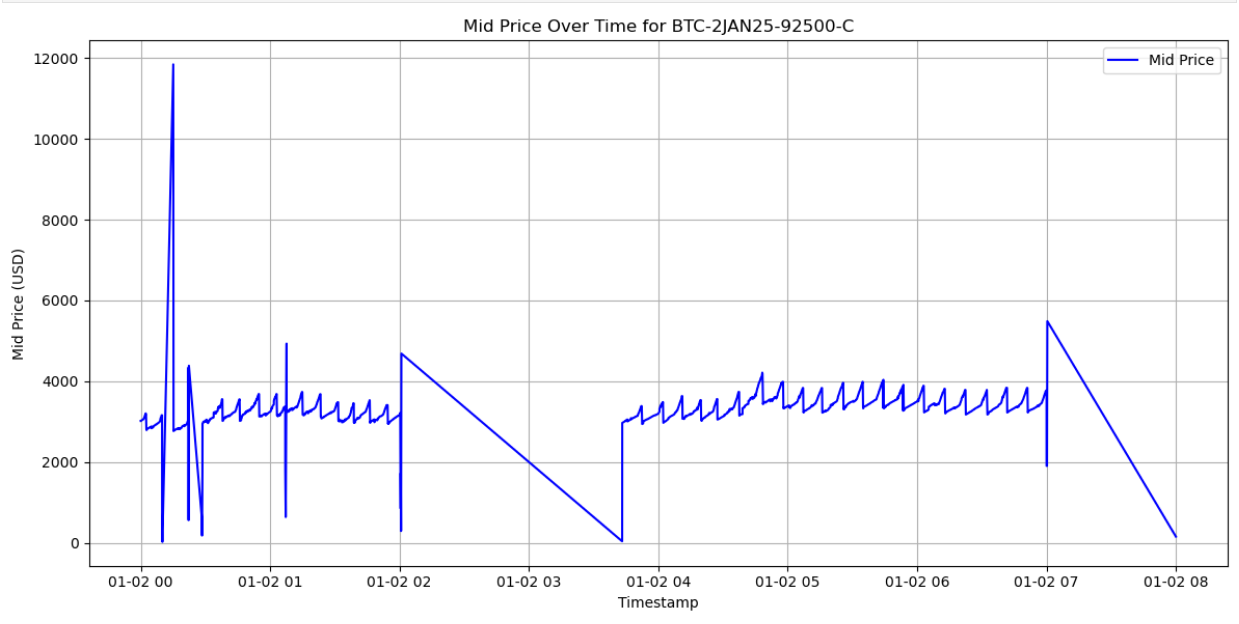

285
Average MAPE after filtering (relative range ≤ 5): 17.7920


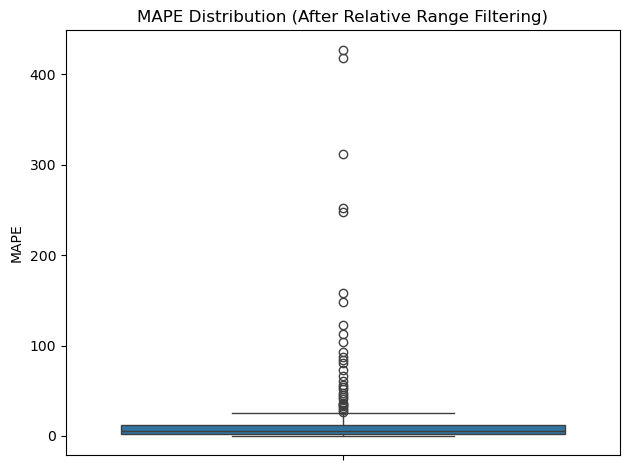

In [49]:
#trying to manually filter on High-Low ratio (relative range) and seeing if it affects average MAPE
threshold = 5 

filtered_metrics_df = metrics_df[
    metrics_df['mid_price_range_80'] <= threshold
]
print(len(filtered_metrics_df))
average_mape = filtered_metrics_df['MAPE'].mean()
print(f"Average MAPE after filtering (relative range ≤ {threshold}): {average_mape:.4f}")

sns.boxplot(y=filtered_metrics_df['MAPE'])
plt.title('MAPE Distribution (After Relative Range Filtering)')
plt.ylabel('MAPE')
plt.tight_layout()
plt.show()

262
Average MAPE after filtering (relative range ≤ 200): 78.7374


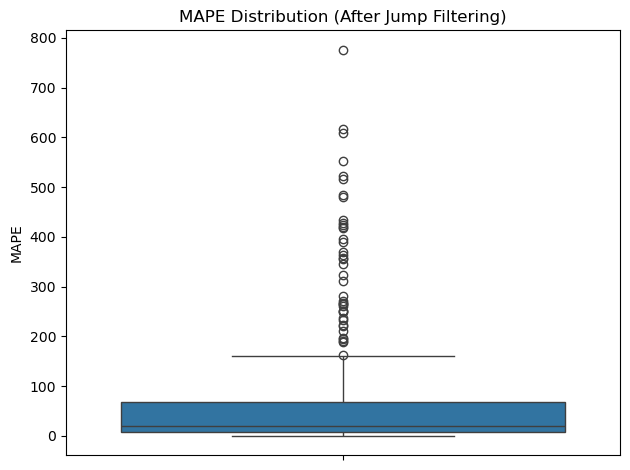

In [55]:
#trying to manually filter on mid-price jump and seeing if it affects average MAPE
threshold = 200

filtered_metrics_df = metrics_df[
    metrics_df['mid_price_jump_80'] <= threshold
]
print(len(filtered_metrics_df))
average_mape = filtered_metrics_df['MAPE'].mean()
print(f"Average MAPE after filtering (relative range ≤ {threshold}): {average_mape:.4f}")

sns.boxplot(y=filtered_metrics_df['MAPE'])
plt.title('MAPE Distribution (After Jump Filtering)')
plt.ylabel('MAPE')
plt.tight_layout()
plt.show()

331
Average MAPE after filtering (relative range ≤ 2e-05): 50.0916


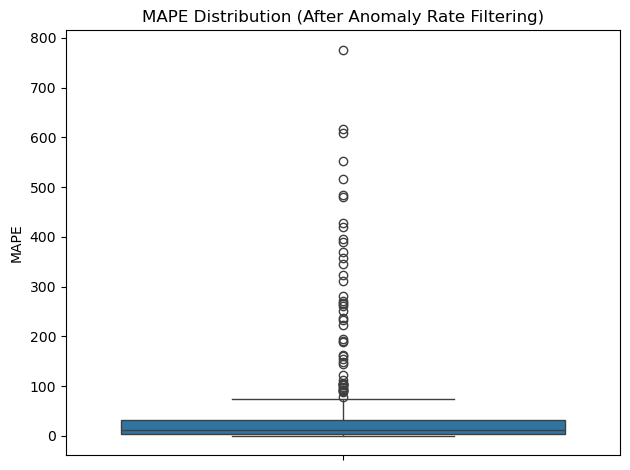

In [60]:
#trying to manually filter on mid-price jump and seeing if it affects average MAPE
threshold = 0.00002

filtered_metrics_df = metrics_df[
    metrics_df['anomaly_rate_80'] <= threshold
]
print(len(filtered_metrics_df))
average_mape = filtered_metrics_df['MAPE'].mean()
print(f"Average MAPE after filtering (relative range ≤ {threshold}): {average_mape:.4f}")

sns.boxplot(y=filtered_metrics_df['MAPE'])
plt.title('MAPE Distribution (After Anomaly Rate Filtering)')
plt.ylabel('MAPE')
plt.tight_layout()
plt.show()

Number of symbols after all filters: 121
Average MAPE after all filters: 20.5497


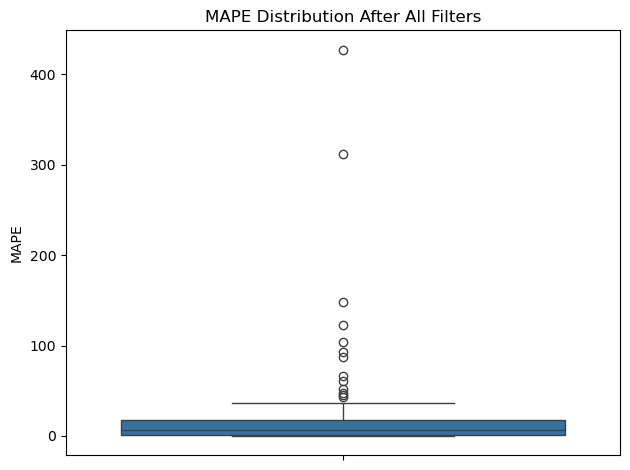

In [65]:
range_threshold = 5
jump_threshold = 200
anomaly_threshold = 0.00002
filtered_all = metrics_df[
    (metrics_df['mid_price_range_80'] <= range_threshold) &
    (metrics_df['mid_price_jump_80'] <= jump_threshold) &
    (metrics_df['anomaly_rate_80'] <= anomaly_threshold)
]

print(f"Number of symbols after all filters: {len(filtered_all)}")
print(f"Average MAPE after all filters: {filtered_all['MAPE'].mean():.4f}")

# Boxplot
sns.boxplot(y=filtered_all['MAPE'])
plt.title('MAPE Distribution After All Filters')
plt.ylabel('MAPE')
plt.tight_layout()
plt.show()


the basis of the next step (classification) will be this df: metrics df. Each symbol has its risk features (input) and its MAPE (target)

In [66]:
metrics_df

,symbol,MAE,RMSE,MAPE,mid_price_range_80,mid_price_jump_80,anomaly_rate_80,mid_price_volatility_ratio_80,good_mape,predicted_good_mape,type_P,type_C,strike
0,BTC-10JAN25-100000-C,1593.489990,1917.442749,1734.929443,1962.260191,25371.566406,0.006887,3.118127,0,0,0,1,100000
1,BTC-10JAN25-101000-C,2286.624756,6384.664551,637.226135,1903.521975,26369.531250,0.005614,2.611579,0,0,0,1,101000
2,BTC-10JAN25-102000-C,2415.062744,2415.732910,801.893127,1423.964035,26545.658203,0.003646,1.786803,0,0,0,1,102000
3,BTC-10JAN25-103000-C,17.807074,17.807076,5.912629,524.264167,7316.587891,0.002662,1.731018,1,0,0,1,103000
4,BTC-10JAN25-104000-C,514.476807,1275.334106,54.504459,365.215309,6732.681152,0.000463,1.310756,0,0,0,1,104000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642,BTC-9JAN25-96500-P,963.558411,994.615784,28.846029,622.292266,15341.894531,0.003820,0.621032,0,0,1,0,96500
1643,BTC-9JAN25-97000-P,123.653221,144.358627,4.822308,11.189144,14366.113281,0.001331,0.257540,1,0,1,0,97000
1644,BTC-9JAN25-97500-P,573.403320,689.096436,14.603807,689.747067,9757.847656,0.002778,0.511465,0,0,1,0,97500
1645,BTC-9JAN25-98000-P,182.282700,197.484909,5.026222,104.991637,4144.570801,0.001331,0.116741,1,1,1,0,98000


### Final conclusion: We see if we filter based on these criteria , we can exclude erratic symbols and increase the MAPE of the remaining symbols. We can automate and optimize the process by implementing a classification model:


# Classification model 

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Average MAPE of predicted good symbols: 5.9554
Number of symbols predicted as good: 369


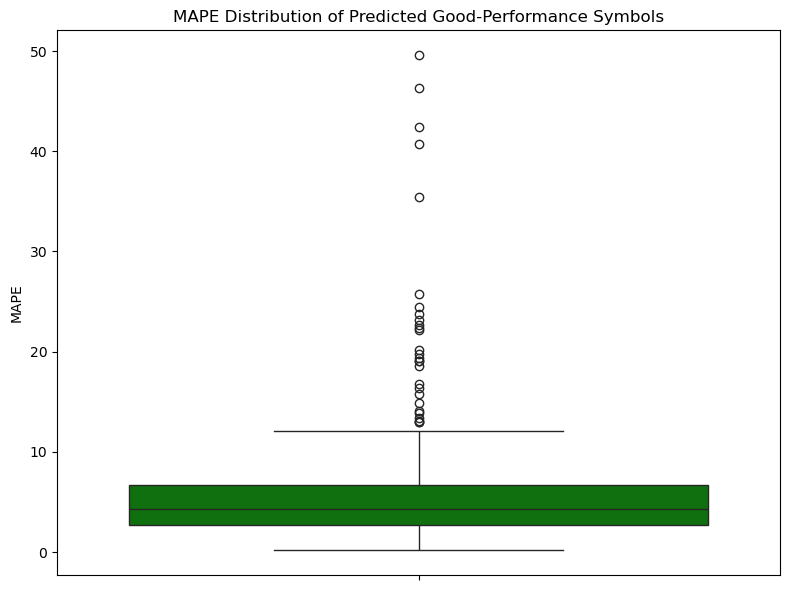

In [69]:
metrics_extended=metrics_df

mape_threshold = 10 
#this threshold was chosen after experimentation, if we decrease it we have less symbols,
# and if we increase it we have high MAPE. Thus we tried to have a balance.
metrics_extended['good_mape'] = (metrics_extended['MAPE'] <= mape_threshold).astype(int)
#  Define Features and Target
features = ['mid_price_range_80', 'mid_price_jump_80', 'anomaly_rate_80', 'mid_price_volatility_ratio_80', 'type_P', 'type_C', 'strike']
X = metrics_extended[features]
y = metrics_extended['good_mape']
#  Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
#simple parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='precision', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

metrics_extended['predicted_good_mape'] = best_rf_model.predict(X)
predicted_good_mape_df = metrics_extended[metrics_extended['predicted_good_mape'] == 1].copy()

if not predicted_good_mape_df.empty:
    average_mape_predicted_good = predicted_good_mape_df['MAPE'].mean()
    print(f"Average MAPE of predicted good symbols: {average_mape_predicted_good:.4f}")

    num_predicted_good = len(predicted_good_mape_df)
    print(f"Number of symbols predicted as good: {num_predicted_good}")

    # Plot the distribution of the predicted good MAPEs
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=predicted_good_mape_df['MAPE'], color='green')
    plt.title('MAPE Distribution of Predicted Good-Performance Symbols')
    plt.ylabel('MAPE')
    plt.tight_layout()
    plt.show()

else:
    print("No symbols were predicted to have good MAPE.")


In [ ]:
good_symbols_set = set(predicted_good_mape_df['symbol'])

df_filtered = df[df['symbol'].isin(good_symbols_set)]

In [ ]:
df_classified_good = df[df['symbol'].isin(good_symbols_set)]

In [ ]:
len(df_classified_good['symbol'].unique())

369

Those symbols selected by the model as expected to yield low MAPE will be the basis of the main experiments